In [1]:
from core.preprocessing import make_small_train, make_small_dev, StatisticalClearSky
import numpy as np
import pandas as pd
df = pd.read_pickle('data/master_dataset.pkl').fillna(0)
df = df.loc['2015-07-15':'2017-07-14']
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind', context='talk')

In [2]:
def plot_trends_and_total(df, start=None, stop=None):
    if start is None:
        start = df.index[0]
    if stop is None:
        stop = df.index[-1]
    cols = df.columns
    fig, axes = plt.subplots(nrows=2, figsize=(12,10), sharex=True)
    df.loc[start:stop].plot(y=cols[:-1], legend=False, linewidth=1, ax=axes[0])
    df.loc[start:stop].plot(y=cols[-1], linewidth=1, ax=axes[1])

/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


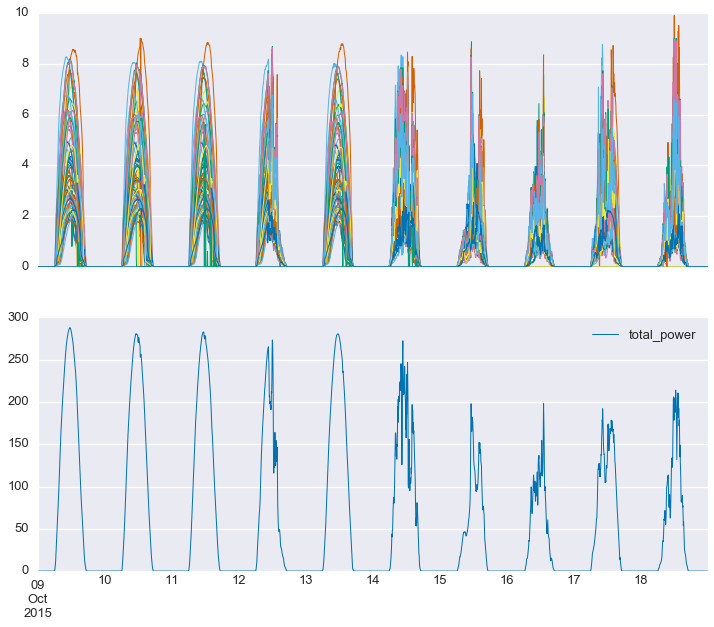

In [3]:
mixed = make_small_train(df, 'mixed')
plot_trends_and_total(mixed)

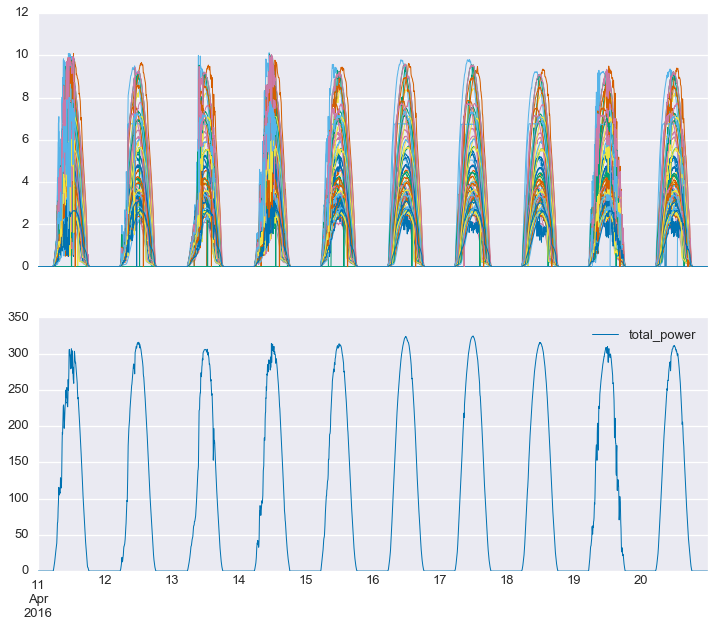

In [4]:
sunny = make_small_train(df, 'sunny')
plot_trends_and_total(sunny)

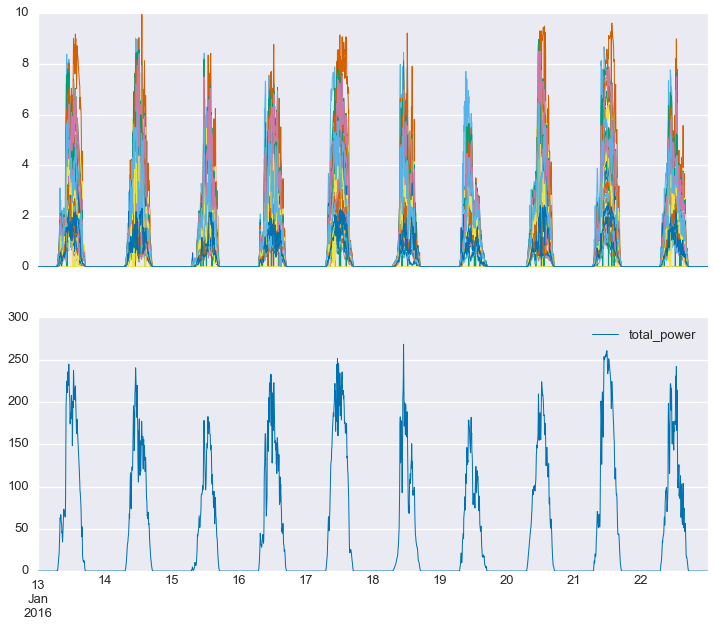

In [5]:
cloudy = make_small_train(df, 'cloudy')
plot_trends_and_total(cloudy)

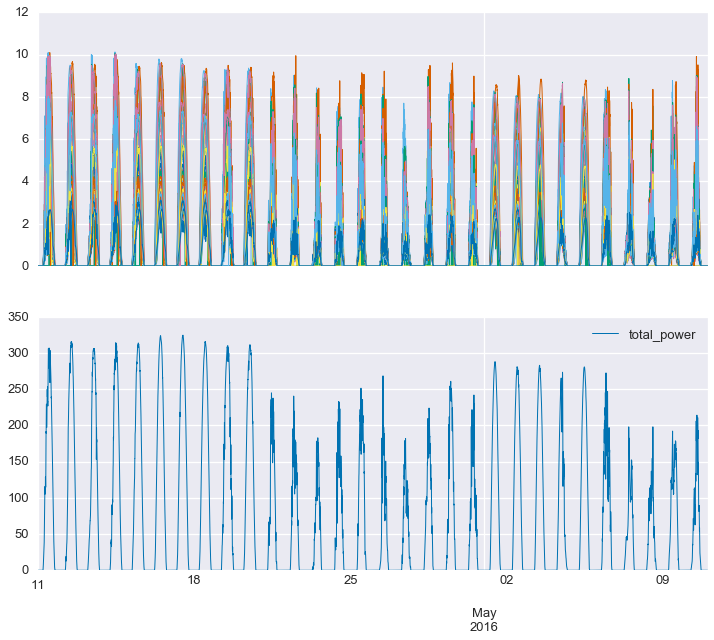

In [6]:
comb = make_small_train(df, 'combined')
plot_trends_and_total(comb)

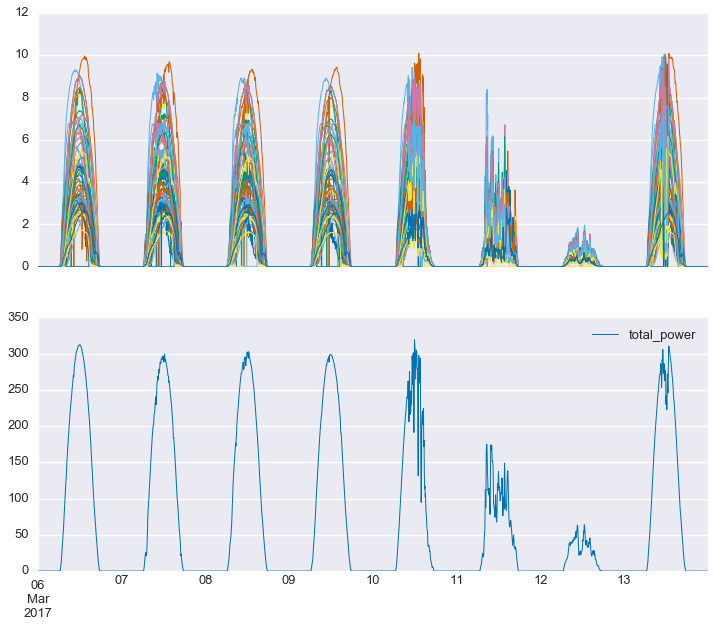

In [7]:
dev = make_small_dev(df)
plot_trends_and_total(dev)

In [8]:
from core.problems import ManyToOneRegression

# Problem parameters
window = 5*12 # window size (to be determined from correlation analysis)
future = 3*12  # prediction window into the future

# Optimization parameters
nepochs = 50
batchsize = 1000

problem = ManyToOneRegression(mixed, window=window, future=future)

/Users/bennetmeyers/.virtualenvs/sc/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
feat = problem.featurize(100)

In [10]:
%time np.array([mixed.iloc[i:i+window, :-1].values.ravel() for i in xrange(len(mixed) - problem.window - problem.future)]).shape

CPU times: user 585 ms, sys: 71.9 ms, total: 656 ms
Wall time: 656 ms


(2784, 4380)

In [11]:
mixed.shape

(2880, 74)

In [12]:
i = 75
mixed.iloc[i:i+window, :-1].values.ravel()

array([ 0.0215,  0.0377,  0.0366, ...,  4.581 ,  6.0522,  1.9671])

In [13]:
scs = StatisticalClearSky(df['S01'])

In [14]:
scs.get_eigenvectors()

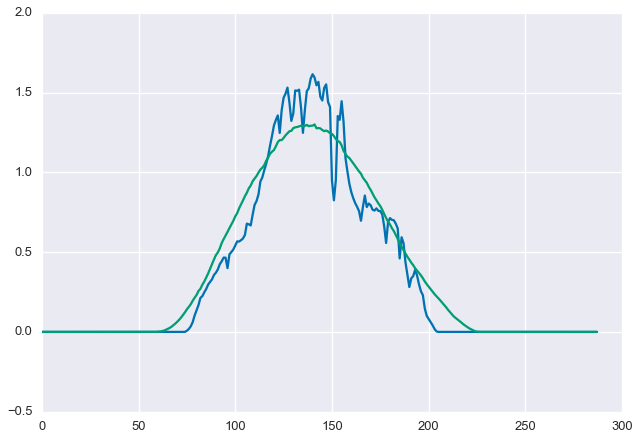

In [16]:
scs.reconstruct_day(day=100, n=2)